In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import pandas as pd
import pickle
from seaborn_plots import rank_corr, ga_plot
from collections import defaultdict
import json
import result_utils as ru

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
new_vuls = {}
full_vuls = {}
intervals = [(0, 28800), (28800, 57600), (57600, 86400)]
vuls = defaultdict(dict)
upper_lmbd = 10

In [22]:
with open('../output/net_dump/vehroutes_new.json', 'r') as f:
    jsondata = json.load(f)

for interval in intervals:
    for lmbd in range(1,upper_lmbd):
        for link in range(1,77):
            #nom_tt = ru.get_subnetwork_tt(jsondata, ru.get_subnet_edges(lmbd, f'{link}_1', nominal=True))
            
            filename = f'../output/net_dump/1.high_correlation/lmbd{lmbd}/traveltime_{link}_1_0_10_{lmbd}_False.json'
            with open(filename) as f:
                try:
                    nom_tt = json.load(f)
                except Exception as e:
                    print(f'{e} : {filename}')
            
            filename = f'../output/net_dump/1.high_correlation/lmbd{lmbd}/traveltime_{link}_1_{interval[0]}_{interval[1]}_{lmbd}_False.json'
            with open(filename) as f:
                try:
                    sub_tt = json.load(f)
                except Exception as e:
                    print(f'{e} : {filename}')

            vuls[lmbd][(link, interval)] = ru.calc_vul(sub_tt, nom_tt, [lmbd, link, interval])

In [3]:
#pickle.dump(vuls, open('sf_vuls.pkl', 'wb'))
vuls = pickle.load(open('sf_vuls.pkl', 'rb'))

In [4]:
sub_vuls_ranks = defaultdict(dict)
sub_vuls_interval_ranks = defaultdict(dict)
intervals = [(0, 28800), (28800, 57600), (57600, 86400)]
for lmbd in vuls:
    vuls[lmbd] = {k: v for k, v in sorted(vuls[lmbd].items(), key=lambda item: item[1], reverse=True)}
    sub_vuls_ranks[lmbd] = {k: i for i, k in enumerate(vuls[lmbd].keys())}
    interval_current_ranks = defaultdict(int)
    for interval in intervals:
        sub_vuls_interval_ranks[lmbd][interval] = {}
    for edge, interval in vuls[lmbd]:
        sub_vuls_interval_ranks[lmbd][interval][edge] = interval_current_ranks[interval]
        interval_current_ranks[interval] += 1
sub_vuls_sorted_ranks = defaultdict(dict)
for lmbd in range(1,10):
    sub_vuls_sorted_ranks[lmbd] = {k:sub_vuls_ranks[lmbd][k] for k in vuls[9].keys()}
full_vuls_ranks = {k:i for i, k in enumerate(vuls[9].keys())}

In [5]:
x = list(sub_vuls_sorted_ranks[lmbd].values())
y = list(full_vuls_ranks.values())

In [6]:
lmbds = [1, 3, 5]
data = defaultdict(dict)
for lmbd in lmbds:
    data[lmbd]['x'] = list(sub_vuls_sorted_ranks[lmbd].values())
    data[lmbd]['y'] = list(full_vuls_ranks.values())


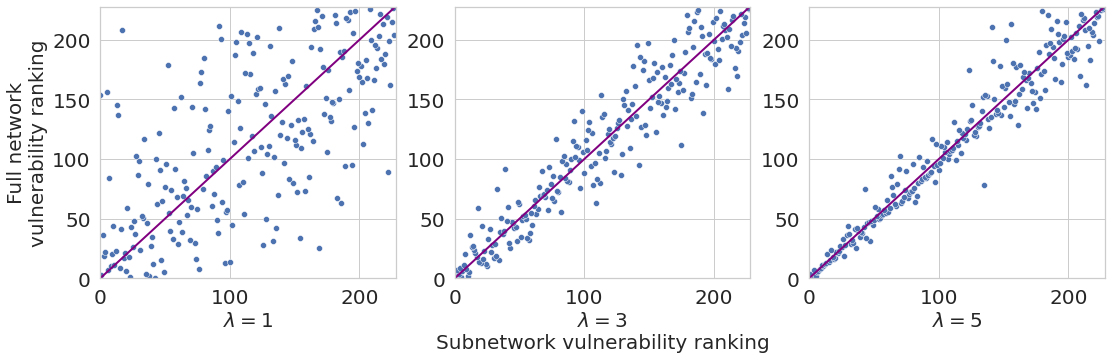

In [19]:
rank_corr(data)

In [39]:
# calculate the spearman's correlation between two variables
from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr
import random
from seaborn_plots import rank_corr
from numpy.random import default_rng

rng = default_rng()


# seed random number generator
seed(1)
# prepare data
total_edges = 672
total_intervals = 3
total_scenarios = total_edges * total_intervals
full_vuls = rand(total_scenarios) * random.randint(15,20)
lmbd1 = full_vuls + (rand(total_scenarios) * rng.integers(low=-29, high=29, size=total_scenarios))
lmbd2 = full_vuls + (rand(total_scenarios) * rng.integers(low=-13, high=13, size=total_scenarios))
lmbd3 = full_vuls + (rand(total_scenarios) * rng.integers(low=-12, high=12, size=total_scenarios))

print(spearmanr(full_vuls, lmbd1))
print(spearmanr(full_vuls, lmbd2))
print(spearmanr(full_vuls, lmbd3))
vuls = {}

full_vul_vals = {i:vul for i, vul in enumerate(full_vuls)}
vuls[1] = {i:vul for i, vul in enumerate(lmbd1)}
vuls[2] = {i:vul for i, vul in enumerate(lmbd2)}
vuls[3] = {i:vul for i, vul in enumerate(lmbd3)}

full_vul_vals = {k: v for k, v in sorted(full_vul_vals.items(), key=lambda item: item[1], reverse=True)}
full_vul_ranks = {k: i for i, k in enumerate(full_vul_vals.keys())}
sub_vuls_ranks = {}
for lmbd in range(1,4):
    vuls[lmbd] = {k: v for k, v in sorted(vuls[lmbd].items(), key=lambda item: item[1], reverse=True)}
    sub_vuls_ranks[lmbd] = {k: i for i, k in enumerate(vuls[lmbd].keys())}

sub_vuls_sorted_ranks = {}
for lmbd in range(1,4):
    sub_vuls_sorted_ranks[lmbd] = {k:sub_vuls_ranks[lmbd][k] for k in full_vul_ranks.keys()}

SpearmanrResult(correlation=0.5017228557263261, pvalue=5.3448706733168744e-129)
SpearmanrResult(correlation=0.8047923399655451, pvalue=0.0)
SpearmanrResult(correlation=0.8316666452839625, pvalue=0.0)


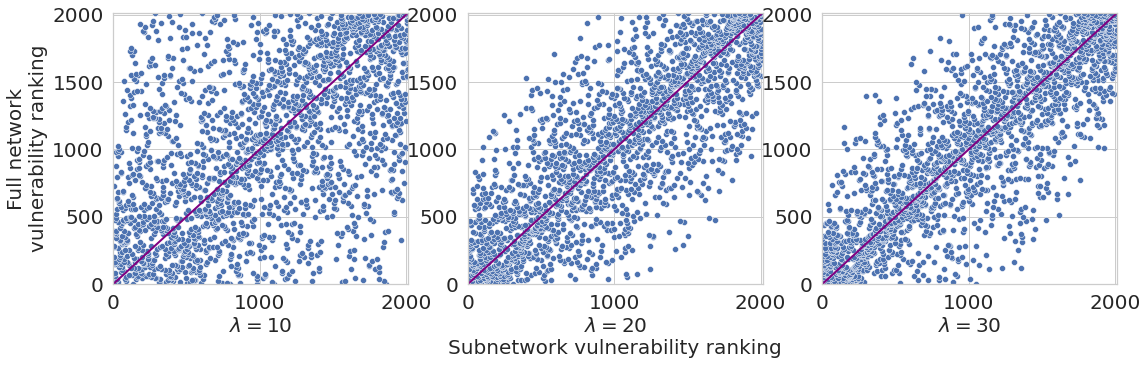

In [40]:
data = defaultdict(dict)
data[10]['x'] = list(sub_vuls_sorted_ranks[1].values())
data[10]['y'] = list(full_vul_ranks.values())

data[20]['x'] = list(sub_vuls_sorted_ranks[2].values())
data[20]['y'] = list(full_vul_ranks.values())

data[30]['x'] = list(sub_vuls_sorted_ranks[3].values())
data[30]['y'] = list(full_vul_ranks.values())
rank_corr(data)

In [2]:
import pickle
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import array
import random

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 4)
hof = pickle.load(open('hof_lmbd3.pkl', 'rb'))
log = pickle.load(open('log_lmbd3.pkl', 'rb'))
pop = pickle.load(open('pop_lmbd3.pkl', 'rb'))
#print(hof[0])
print(log[32]['max'])
max_vals = []
avg_vals = []
for step in range(len(log)):
    max_vals.append(abs(log[step]['max']))
    avg_vals.append(abs(log[step]['avg']))

-1.2603133522311727


In [21]:
hof = pickle.load(open('hof_lmbd2.pkl', 'rb'))
log = pickle.load(open('log_lmbd2.pkl', 'rb'))
pop = pickle.load(open('pop_lmbd2.pkl', 'rb'))
max_vals2 = []
avg_vals2 = []
for step in range(len(log)):
    max_vals2.append(abs(log[step]['max']))
    avg_vals2.append(abs(log[step]['avg']))

In [22]:
for i in range(30, 41):
    max_vals[i] = max_vals[30]

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('./ga_results/budget_15.csv',sep='\t',)
np.flip(data['Best'].values*-1.0)

In [23]:
max_vals2 = [1.3636, 1.3636 ,1.3636 ,1.3236 ,1.3236 ,1.2836 ,1.2836 ,1.2636 , 1.2636 ,
       1.2636 , 1.24822, 1.1782 , 1.1782 , 1.10086, 1.10086, 1.10086,
       1.10086, 1.10086, 1.10086, 1.10086, 1.10086, 1.10086, 1.09324,
       1.09324, 1.09324, 1.09324, 1.09324, 1.09324, 1.09324, 1.09324,
       1.09324, 1.09324, 1.10086, 1.10086, 1.10086, 1.10086, 1.10086,
       1.10086, 1.10086, 1.10086, 1.10086]
n1 = np.random.normal(0, 0.007, np.array(max_vals).shape)
n2 = np.random.normal(0, 0.007, np.array(max_vals).shape)
max_vals3 = max_vals + n1
max_vals2= max_vals2+ n2

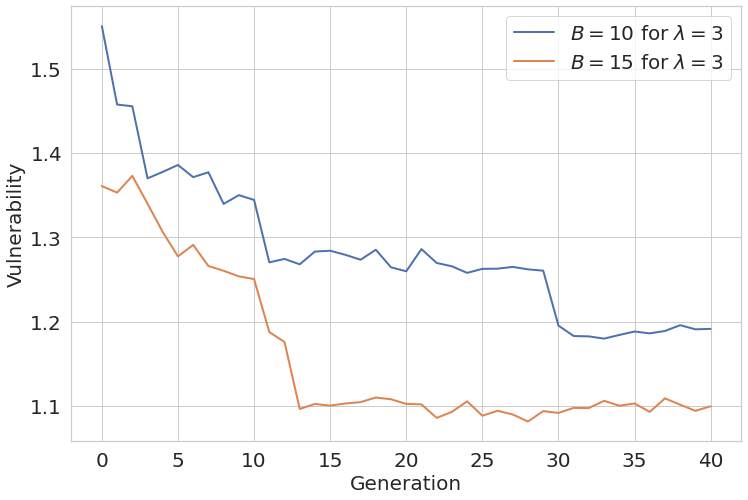

In [29]:
ga_plot(max_vals3, max_vals2)